<a href="https://colab.research.google.com/github/leonardoLavagna/TCGA-PRAD/blob/main/DEPM_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPM First Project 
# Prostate Adenocarcinoma TCGA-PRAD  



## Installation of the required packages, libreries and set up
#### Installation of required packages

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [ ]:
BiocManager::install("TCGAbiolinks")

In [ ]:
BiocManager::install("SummarizedExperiment")

In [ ]:
BiocManager::install("DESeq2")

In [ ]:
BiocManager::install("netDx")

In [ ]:
BiocManager::install("WGCNA")

In [ ]:
install.packages("igraph")

In [ ]:
install.packages("cowplot")

In [ ]:
install.packages("psych")

#### Required libraries

In [ ]:
# Library to handle DEGs

library(DESeq2)

In [ ]:
# Libraries for merging and cleaning the data

library(dplyr)
library(stringr)

In [12]:
# Libraries for data extraction

library(TCGAbiolinks)
library(SummarizedExperiment)

In [ ]:
# Libraries for plotting

library(cowplot)
library(tidyverse)
library(igraph)

In [98]:
# For correlation networks

library(psych)      
library(WGCNA)

#### Directory tree setup

In [16]:
proj <- "TCGA-PRAD"
dir.create(file.path(proj))

## PART I
## DATA 

### I.1 Getting the Data 
For references, see https://portal.gdc.cancer.gov/projects/TCGA-PRAD.

In [ ]:
# Extract primary tumor data

rna.query.C <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Primary Tumor") 
GDCdownload(query = rna.query.C, directory = "GDCdata", method = "api")
rna.data.C <- GDCprepare(rna.query.C)
rna.expr.data.C <- assay(rna.data.C)
rna.genes.info.C <- rowRanges(rna.data.C)
rna.sample.info.C <- colData(rna.data.C)
write.table(rna.expr.data.C, file=file.path(proj,paste(proj, "_rna_expr_data_C.txt",sep = "")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.C@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.C@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


In [ ]:
# Extract solid tissue normal data

rna.query.N <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Solid Tissue Normal") 
GDCdownload(query = rna.query.N, directory = "GDCdata", method = "api")
rna.data.N <- GDCprepare(rna.query.N)
rna.expr.data.N <- assay(rna.data.N)
rna.genes.info.N <- rowRanges(rna.data.N)
rna.sample.info.N <- colData(rna.data.N)
write.table(rna.expr.data.N, file=file.path(proj,paste(proj, "_rna_expr_data_N.txt",sep="")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.N@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.N@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


### I.2 Processing the extracted data

#### 1) read the condition (tumor) TCGA-PRAD dataset

In [133]:
rna_expr_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_C.txt", header=TRUE, sep="", check.names = F) 
#View(rna_expr_data_C)

In [20]:
rna_gene_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_C.txt", header=FALSE, sep="", check.names = F) 
# View(rna_gene_data_C)

In [130]:
rna_patients_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_C.txt", header=FALSE, sep="", check.names = F) 
#View(rna_patients_data_C)

#### 2) read the normal (natural) TCGA-PRAD dataset

In [22]:
rna_expr_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_N.txt", header=TRUE, sep="", check.names = F) 
# View(rna_expr_data_N)

In [135]:
rna_gene_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_N.txt", header=FALSE, sep="", check.names = F) 
#View(rna_gene_data_N)

In [132]:
rna_patients_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_N.txt", header=FALSE, sep="", check.names = F) 
#View(rna_patients_data_N)

#### 3) read patient's data

In [25]:
clinical.query<-GDCquery_clinic(project = proj, type = "clinical", save.csv = FALSE)
write.csv(clinical.query, file = file.path(proj,paste(proj, "_clinical_data.txt",sep="")), row.names = FALSE, quote = FALSE)

In [129]:
clinical_data <- read.csv2("./TCGA-PRAD/TCGA-PRAD_clinical_data.txt", header = FALSE, sep=",")
colnames(clinical_data) <- clinical_data[1,]; clinical_data <- clinical_data[-1,] 
#View(clinical_data)

#### 4) Intersection and cleaning of partecipants' data

In [136]:
# merge common patients

common_patients <- merge(rna_patients_data_C, rna_patients_data_N, by.x="V1", by.y="V1")

In [28]:
# subtract useless column between the two expression data.frames using a boolean mask
# check for multiple patterns and use the boolean mask created to filter through the columns

mask_tuned_patientsC <- str_detect(as.vector(colnames(rna_expr_data_C)), paste(as.vector(unlist(common_patients)), collapse = '|'))
rna_expr_data_C <- rna_expr_data_C[, mask_tuned_patientsC]

mask_tuned_patientsN <- str_detect(as.vector(colnames(rna_expr_data_N)), paste(as.vector(unlist(common_patients)), collapse = '|')) 
rna_expr_data_N <- rna_expr_data_N[, mask_tuned_patientsN] 

In [29]:
# cleaning the rows with any zero values through each of the two dataframes

rna_expr_data_C <- rna_expr_data_C[apply(rna_expr_data_C, 1, function(x) all(x!=0)),]
rna_expr_data_N <- rna_expr_data_N[apply(rna_expr_data_N, 1, function(x) all(x!=0)),]


In [30]:
# row-wise intersection (genes) of the two dataframes

rna_expr_data_C <- subset(rna_expr_data_C, rownames(rna_expr_data_C) %in% rownames(rna_expr_data_N))
rna_expr_data_N <- subset(rna_expr_data_N, rownames(rna_expr_data_N) %in% rownames(rna_expr_data_C))


In [31]:
# Verify that all the duplicate partecipants have been removed

# dummy_split <- as.data.frame(t(apply(common_patients, 1, function(k){
# sym <- unlist(strsplit(k, split = "-"))
# return(c(sym[1], sym[2], sym[3]))
# }))); colnames(dummy_split) <- c("A", "B", "C"); dummy_split[duplicated(dummy_split$C),]


## PART II
## Differentially Expressed Genes (DEGs)

### II.2 Processing 

#### 1) Merging of the columns

In [32]:
# sort the column names for each dataset before merging them

rna_expr_data_C <- rna_expr_data_C[,order(colnames(rna_expr_data_C))]
rna_expr_data_N <- rna_expr_data_N[,order(colnames(rna_expr_data_N))]

In [33]:
# Rename the columns

addInfoData <- function(dt, info){
  colInfo <- c()

  for(name in colnames(dt)){
    colInfo <- c(colInfo, paste(name, info, sep=""))  
  }
  
  colnames(dt) <- colInfo
  return(dt)
}

rna_expr_data_C <- addInfoData(rna_expr_data_C, "_tumor")
rna_expr_data_N <- addInfoData(rna_expr_data_N, "_normal")


In [34]:
# Merge the columns, sorted and aggregated

full_dt <- cbind(rna_expr_data_N, rna_expr_data_C) 
#View(full_dt)

#### 2) Additional informations

In [35]:
# create a dataset with additional information

PartecipantsCondition <- data.frame(partecipants = colnames(full_dt),
                                    condition = NA) 
PartecipantsCondition <- as.data.frame(t(apply(PartecipantsCondition, 1, function(x){
    if(grepl("tumor", x["partecipants"]))
      return(c(x["partecipants"], condition = "tumor"))
    else
      return(c(x["partecipants"], condition = "normal"))
})));

In [ ]:
# creating the Object of our merged matrix to be "DESQued"

DESQ_dt <- DESeqDataSetFromMatrix(countData = full_dt,
                                  colData = PartecipantsCondition,
                                  design= ~ condition)

#### 3) Remove the genes where there are very few reads
*Remark:* This processing step will reduce the memory size of the actual dataset, and increase also the future transformation and testing functions.

In [37]:
# Here we perform a minimal pre-filtering to keep only rows that have at least 10 reads total. 
# Note that more strict filtering to increase power is automatically applied via 
# independent filtering on the mean of normalized counts within the results function.

keep <- rowSums(counts(DESQ_dt)) >= 10 # this could be a first threshold for us... more strict less genes
DESQ_dt <- DESQ_dt[keep,]

#### 4) Tresholding
*Remark:* here we get the results, obtaining the correction FDR through different tests Its important to keep track of the adjpvalue

In [38]:
DESQ_dtOutput <- DESeq(DESQ_dt)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 602 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [39]:
# this applies a threshold of alpha = 0.05, to make correction of different tests applied, 
# we apply some corrections optimizing the number of genes which will have an adjusted p value below a given FDR cutoff, 
# alpha = 0.05 

res <- results(DESQ_dtOutput, alpha = 0.05, lfcThreshold = 1.2)  

*Remark:* LFC means Log Fold Change. Recall that if LFC > 0 then the number of genes is up-regulated and viceversa (down-regulated < 0).  Moreover LFC > 0 means more expression in NORMAL condition, and LFC < 0  menas is more expression in TUMOR condition.



In [40]:
# Display the summary of the results

summary(res)


out of 18271 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.20 (up)    : 49, 0.27%
LFC < -1.20 (down) : 120, 0.66%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### 4) Plots

In [41]:
# differentially expressed gene ordered from the lower at the larger value of adjustedPvalue

resOrdered <- res[order(res$padj), ]

In [42]:
# versus conditions

resultsNames(DESQ_dtOutput)

[1] "Intercept"                 "condition_tumor_vs_normal"

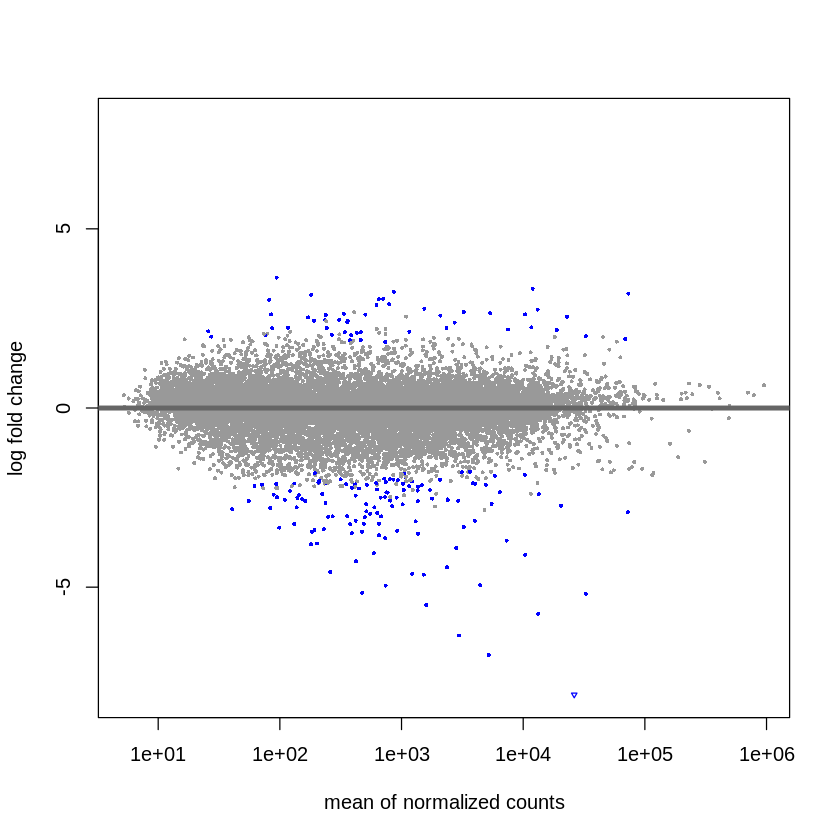

In [43]:
# the function plotMA shows the log2 fold changes attributable to a given variable 
# over the mean of normalized counts for all the samples in the DESeqDataSet. 
# Points will be colored red if the adjusted p value is less than 0.1. 
# Points which fall out of the window are plotted as open triangles pointing either up or down.
 
plotMA(res, ylim = c(-8, 8))

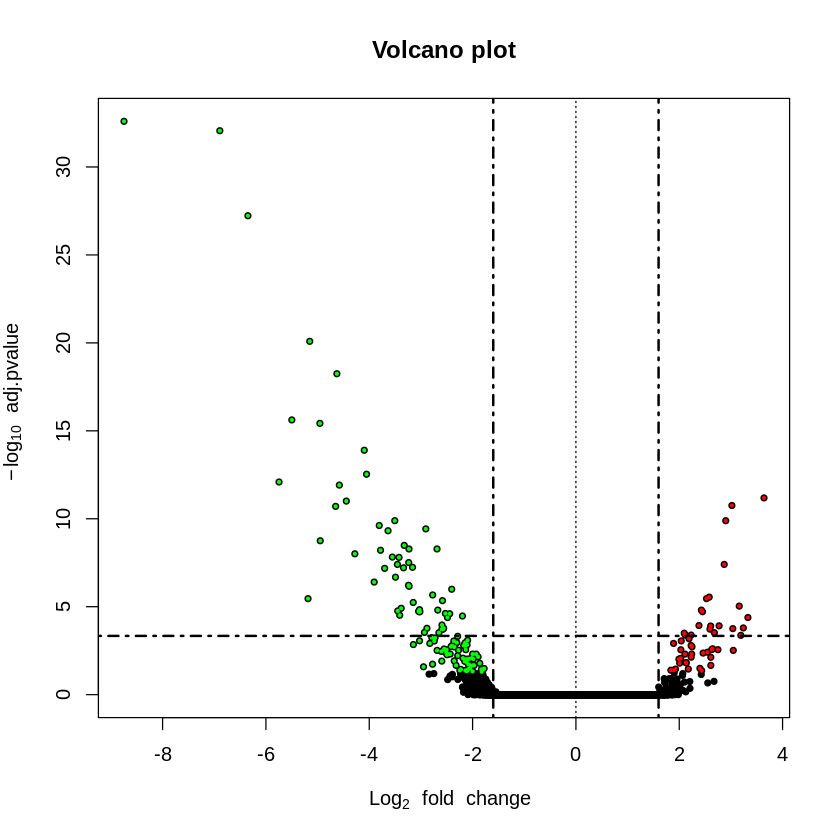

In [78]:
# Volcano Plot
# See https://en.wikipedia.org/wiki/Fold_change

topT <- as.data.frame(res)

#Adjusted P values (FDR Q values)
with(topT, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~adj.pvalue)))
with(subset(topT, padj<=0.05 & log2FoldChange>=1.2), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))
with(subset(topT, padj<=0.05 & log2FoldChange<= -1.2), points(log2FoldChange, -log10(padj), pch=20, col="green", cex=0.5))

#Add lines 
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-1.6, col="black", lty=4, lwd=2.0)
abline(v=1.6, col="black", lty=4, lwd=2.0)
abline(h=-log10(max(topT$pvalue[topT$padj<=0.05], na.rm=TRUE)), col="black", lty=4, lwd=2.0)


## PART III
## Co-expression networks

### III.1 Extract the relevant data from the differentially expressed ordered gene seen in II.2

In [45]:
# extract the filtered DEGs

res_save <- subset(resOrdered, padj <= 0.05)
final_dt <- as.data.frame(res_save)

In [46]:
# extract the genes 

genes_passed <- rownames(final_dt)

### III.2 Processing

In [47]:
# filter the two datasets expressed in tumor and normal 

rna_expr_data_C <- rna_expr_data_C[genes_passed, ]
rna_expr_data_N <- rna_expr_data_N[genes_passed, ]

In [48]:
# create the correlation datasets for plotting the network for each graph

co_net_corr_dataC <- cor(t(rna_expr_data_C), method = "pearson")
co_net_corr_dataN <- cor(t(rna_expr_data_N), method = "pearson")

In [49]:
# log-transform FPKM data using log2(x+1) of each count
# See https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

rna_expr_data_C <- log2(rna_expr_data_C+1)
rna_expr_data_N <- log2(rna_expr_data_N+1)

### III.3 Plots and Trasholding

In [51]:
distroRho_pearsC <- co_net_corr_dataC[upper.tri(co_net_corr_dataC)]
distroRho_pearsN <- co_net_corr_dataN[upper.tri(co_net_corr_dataN)]

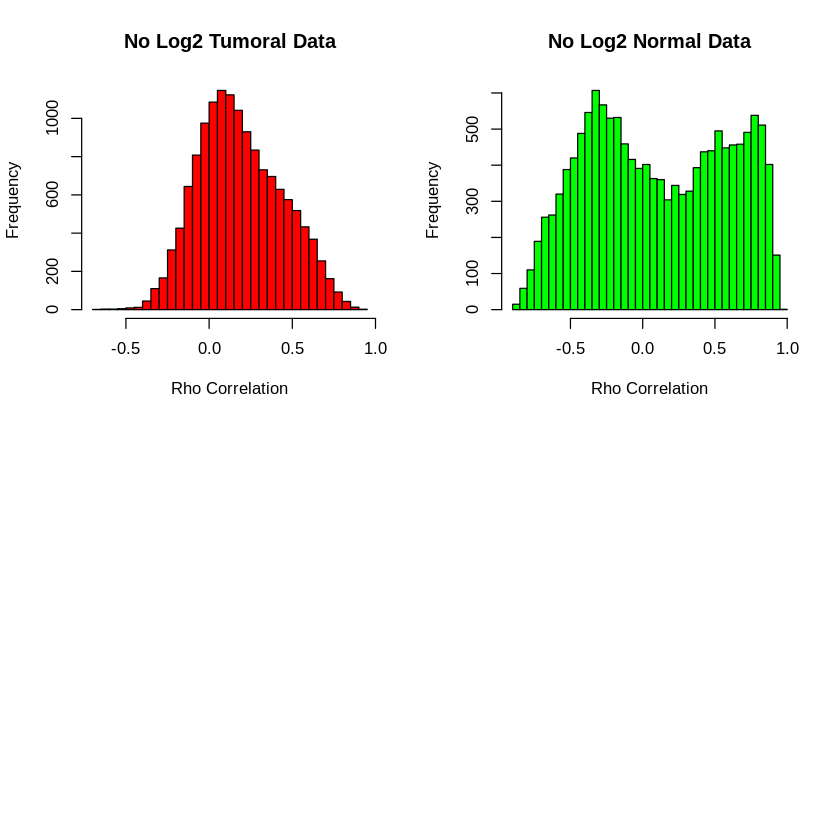

In [52]:
# plot the distribution of the correlations to naively choose a good trashold 

par(mfrow = c(2, 2))
hist(distroRho_pearsC, main = "No Log2 Tumoral Data", col = "red", xlab = "Rho Correlation", breaks = 50)
#points(x = 0.5, y = 0.0, pch = 20, col = "black", cex = 2) # x=0.5 to change accordingly 
hist(distroRho_pearsN, main = "No Log2 Normal Data", col = "green", xlab = "Rho Correlation", breaks = 50)
#points(x = 0.5, y = 0.0, pch = 20, col = "black", cex = 2) # x=0.5 to change accordingly 

In [53]:
# these are probably the threshold candidates 
quantile(abs(distroRho_pearsC))
quantile(abs(distroRho_pearsN))
# Choose trashold = 0.4 as shown below

0%          25%          50%          75%         100% 
3.095782e-05 8.767702e-02 1.950826e-01 3.701449e-01 9.162925e-01

0%          25%          50%          75%         100% 
5.621796e-05 2.186582e-01 4.119146e-01 6.251452e-01 9.522927e-01

### III.4 Fine tuned trasholding

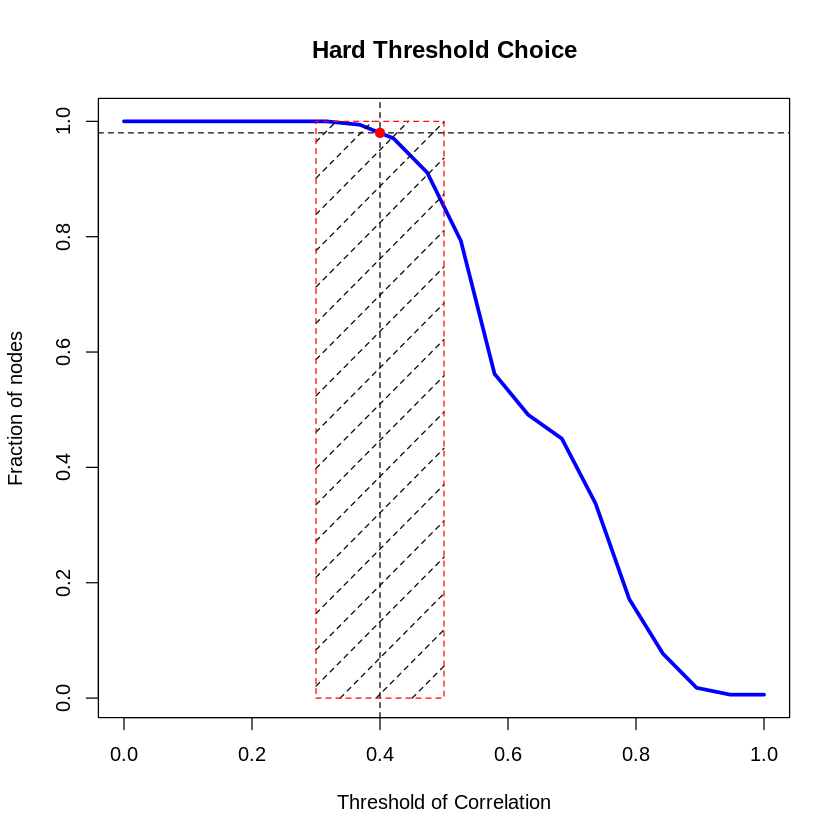

In [54]:
# Find a good threshold 
# Emulate Fiscon lecture (see materials of last year)
# https://classroom.google.com/c/Mjg4MDY4MjkxNDMw

fractionNodes <- function(graph){
  v_graph <- length(V(graph))
  component <- components(graph)
  ind <- which(component$membership == which.max(component$csize))
  LCC <- induced_subgraph(graph , V(graph)[ind])
  v_LCC <- length(V(LCC))
  
  frac_node_LCC <- v_LCC / v_graph
  return(frac_node_LCC)
}

OptimalThresholding <- function(dt, dt2, x){
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(dt), method = "spearman")
  co_net_corr_dataN <- cor(t(dt2), method = "spearman")
  
  tsh <- x
  co_net_corr_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
  co_net_corr_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)
  
  gC <- graph_from_adjacency_matrix(co_net_corr_dataC, diag = FALSE)
  gN <- graph_from_adjacency_matrix(co_net_corr_dataN, diag = FALSE)
  
  fracNodes_C <- fractionNodes(gC)
  fracNodes_N <- fractionNodes(gN)
  
  return(mean(fracNodes_C, fracNodes_N))
}

possibletsh <- seq(0, 1, length.out = 20)
densities <- unlist(lapply(possibletsh, function(x){
  return(OptimalThresholding(rna_expr_data_C, rna_expr_data_N, x))
}))

plot(possibletsh, densities, col = "blue", type = "l", lwd = 3, xlab = "Threshold of Correlation", ylab = "Fraction of nodes", main = "Hard Threshold Choice")
rect(xleft = 0.3, ybottom = 0.0, xright = 0.5, ytop = 1.0, density = 5, border = "red", lty = 2, lwd = 1)


abline(h = 0.98, lty=2)
abline(v = 0.4, lty=2)
points(x = 0.4, y = 0.98, pch = 20, col = "red", cex = 1.5) # this is our preferable naive-hard thresholding


### III.5 Hubs of genes

### 1) Graph creation and plots

In [55]:
# binary masks

tsh <- 0.4 
co_net_corrBinary_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
co_net_corrBinary_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)

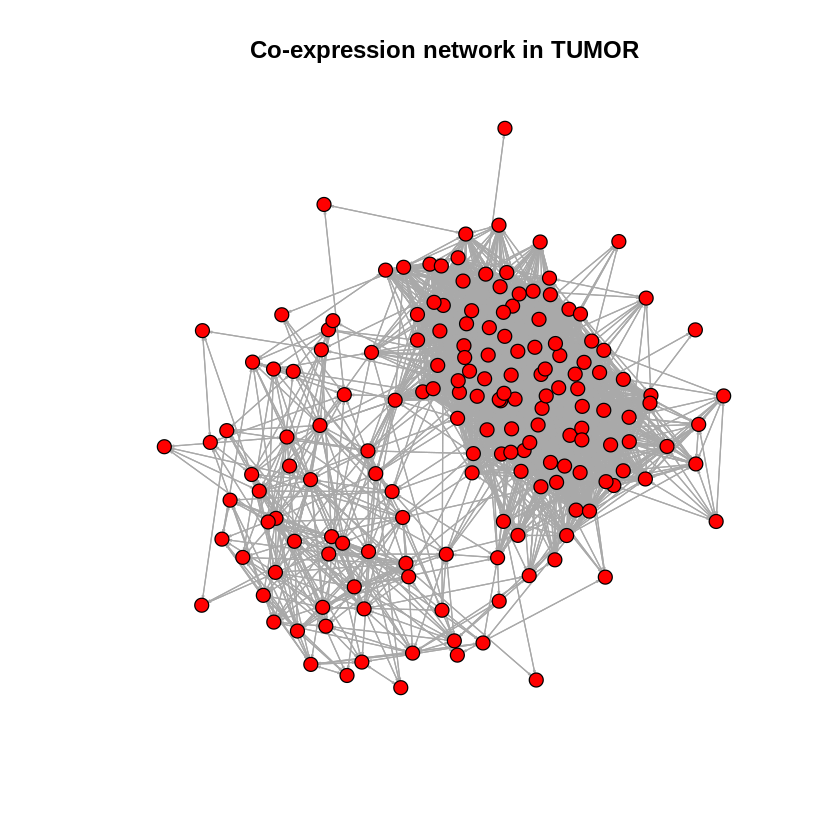

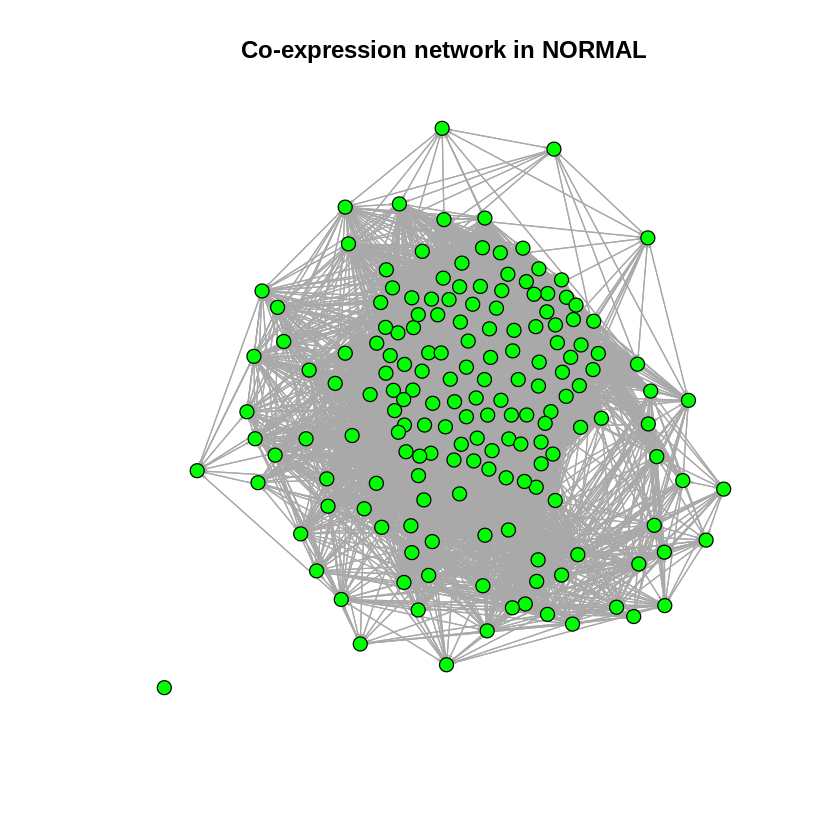

In [56]:
# create the graph

par(mfrow=c(1,1))
gC <- graph_from_adjacency_matrix(co_net_corrBinary_dataC, diag = FALSE)
plot(gC, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "red", main = "Co-expression network in TUMOR",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) # , vertex.label.dist = .8 and .y, vertex.label.cex=1


gN <- graph_from_adjacency_matrix( co_net_corrBinary_dataN, diag = FALSE)
plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "green", main = "Co-expression network in NORMAL",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) # , vertex.label.dist = .8 and .y, vertex.label.cex=1


### 2) Find the Hubs and plots

In [57]:
# degree distribution of the graphs, extract the 5% of HUBS, in their conditions

par(mfrow=c(1,2))
dgC <- degree(gC)
dgN <- degree(gN)
hubs_C <- sort(degree(gC, v = V(gC), mode = "all"), decreasing = TRUE) # normalized TRUE
hubs_C <- hubs_C[1:floor(0.05 * length(hubs_C))] 
hubs_N <- sort(degree(gN, v = V(gN), mode = "all"), decreasing = TRUE) # normalized TRUE
hubs_N <- hubs_N[1:floor(0.05 * length(hubs_N))] 

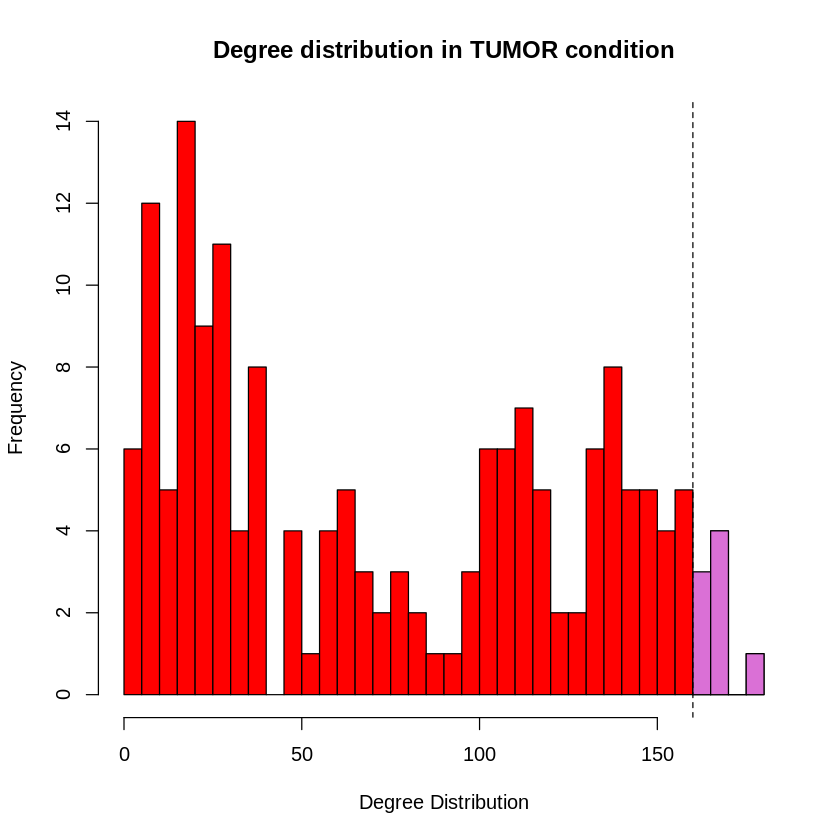

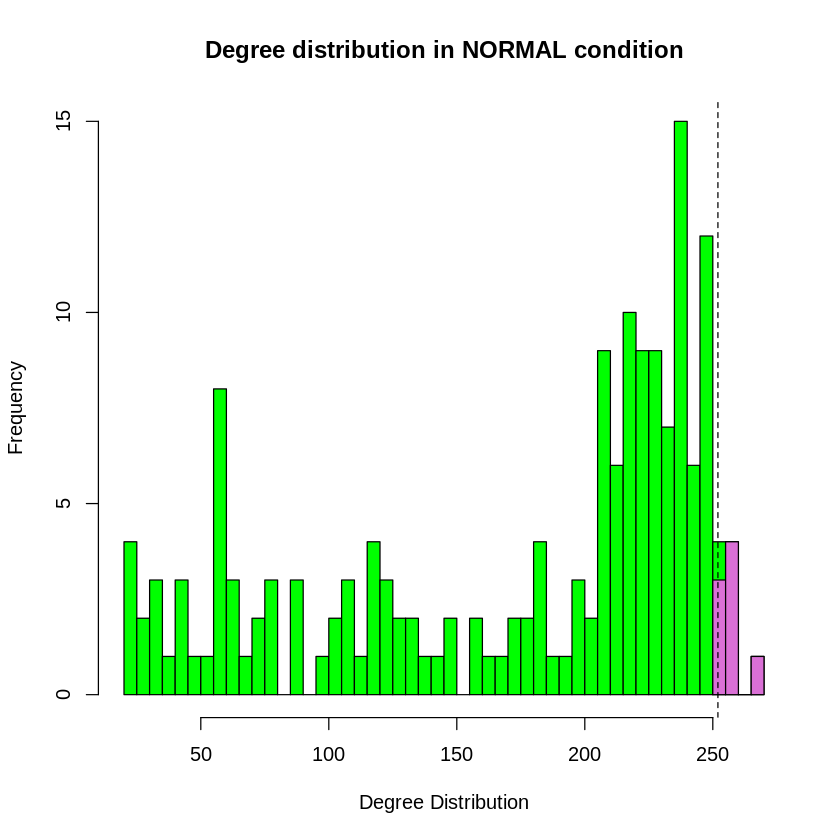

In [58]:
# plot the distribution highliting the 5% of hubs

hist(dgC[dgC != 0], main = "Degree distribution in TUMOR condition", col = "red", xlab = "Degree Distribution", breaks = 50)
hist(hubs_C, add = T, col = "orchid")
abline(v = tail(hubs_C, n=1), lty = 2)
hist(dgN[dgN != 0], main = "Degree distribution in NORMAL condition", col = "green", xlab = "Degree Distribution", breaks = 50)
hist(hubs_N, add = T, col = "orchid")
abline(v = tail(hubs_N, n=1), lty = 2)

In [59]:
# find the hubs 

namesHUBS_C <- names(hubs_C)
namesHUBS_N <- names(hubs_N)

namesHUBS_C_df <- data.frame(gene = namesHUBS_C, degree = hubs_C, row.names = 1:length(namesHUBS_C)); namesHUBS_C_df
namesHUBS_N_df <- data.frame(gene = namesHUBS_N, degree = hubs_N, row.names = 1:length(namesHUBS_N)); namesHUBS_N_df

,gene,degree
,<chr>,<dbl>
1,ENSG00000138356.14,178
2,ENSG00000120885.22,166
3,ENSG00000170915.9,166
4,ENSG00000176928.7,166
5,ENSG00000244509.4,166
6,ENSG00000131620.17,164
7,ENSG00000239713.9,162
8,ENSG00000152137.8,160


,gene,degree
,<chr>,<dbl>
1,ENSG00000260228.6,266
2,ENSG00000211695.2,260
3,ENSG00000119547.6,256
4,ENSG00000136840.19,256
5,ENSG00000125257.16,256
6,ENSG00000176928.7,254
7,ENSG00000103485.19,252
8,ENSG00000255545.8,252


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


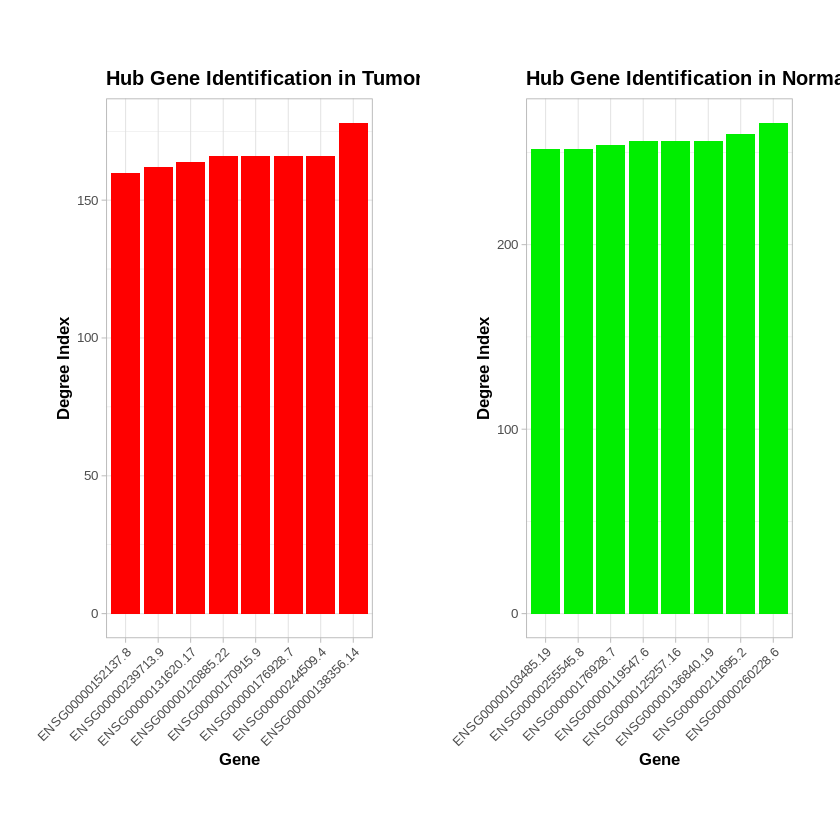

In [60]:
histcol <- c("degree_N" = "green2", "degree" = "red")
hub_gene_C_plot <- ggplot(data = namesHUBS_C_df, aes(x = reorder(gene, degree), y = degree)) +
                      geom_col(aes(x = reorder(gene, degree), y = degree, fill = "degree")) +
                      theme_light() + 
                      theme(text = element_text(size=10),
                            axis.text.x = element_text(angle = 45,hjust = 1),
                            axis.title.x = element_text(face="bold"),
                            axis.title.y = element_text(face="bold"),
                            plot.margin=unit(c(t = 1.5, r = 1, b = 1.5, l = 1.2), "cm"),
                            plot.title = element_text(face = "bold")) +
                      labs( y = "Degree Index", x = "Gene") +
                      scale_fill_manual(values= histcol) +
                      ggtitle("Hub Gene Identification in Tumor Condition") +
                      guides(fill=FALSE)

hub_gene_N_plot <- ggplot(data = namesHUBS_N_df, aes(x = reorder(gene, degree), y = degree)) +
                      geom_col(aes(x = reorder(gene, degree), y = degree, fill = "degree_N")) +
                      theme_light() + 
                      theme(text = element_text(size=10),
                            axis.text.x = element_text(angle = 45,hjust = 1),
                            axis.title.x = element_text(face="bold"),
                            axis.title.y = element_text(face="bold"),
                            plot.margin=unit(c(t = 1.5, r = 1, b = 1.5, l = 1.2), "cm"),
                            plot.title = element_text(face = "bold")) +
                      labs( y = "Degree Index", x = "Gene") +
                      scale_fill_manual(values = histcol) +
                      ggtitle("Hub Gene Identification in Normal Condition") +
                      guides(fill=FALSE)

plot_grid(hub_gene_C_plot, hub_gene_N_plot, labels = NULL)

### 3) Hubs in common (Tumor and Normal)

In [61]:
# Common Hubs

intersect(namesHUBS_C, namesHUBS_N) 

[1] "ENSG00000176928.7"

In [62]:
## ENSG00000176928.7
## A receptor gene involved on bring much signals and get two-way communication answers with other gene...
## Check the closeness to confirm

sort(closeness(gC), decreasing = T)[1] 

ENSG00000120885.22 
       0.003636364

### 4) Extra Statistics about Hubs

In [63]:
# # Up-regulated  (Tumor)
upgenes <- final_dt[final_dt$log2FoldChange >= 1.2, ]
hub_upgenes <- na.omit(upgenes[namesHUBS_C, ]) # empty 

# Down-regulated (Tumor)
downgenes <- final_dt[final_dt$log2FoldChange <= 1.2, ]
hub_downgenes <- na.omit(downgenes[namesHUBS_C, ])

# Up-regulated (Normal)
upgenes_N <- final_dt[final_dt$log2FoldChange >= 1.2, ]
hub_upgenes_N <- na.omit(upgenes_N[namesHUBS_N, ])

# # Down-regulated (Normal)
downgenes_N <- final_dt[final_dt$log2FoldChange <= 1.2, ]
hub_downgenes_N <- na.omit(downgenes_N[namesHUBS_N, ])

# e.g
hub_downgenes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000138356.14,3851.1110,-2.096393,0.1937480,-4.626591,3.717335e-06,8.085647e-04
ENSG00000120885.22,72647.6598,-2.905137,0.2349149,-7.258528,3.913241e-13,3.763096e-10
ENSG00000170915.9,1785.4053,-2.527077,0.2466518,-5.380366,7.433438e-08,2.425292e-05
ENSG00000176928.7,350.6204,-2.129471,0.2081403,-4.465600,7.984480e-06,1.535626e-03
ENSG00000244509.4,3649.8892,-1.776065,0.1583478,-3.637975,2.747905e-04,3.260193e-02
ENSG00000131620.17,5496.8218,-2.673804,0.2689698,-5.479442,4.266703e-08,1.559139e-05
ENSG00000239713.9,930.1250,-2.016160,0.2033592,-4.013392,5.985243e-05,8.420090e-03
ENSG00000152137.8,10286.8084,-1.860382,0.1725229,-3.827792,1.292978e-04,1.652028e-02


## PART IV 
## Differential Co-expressed Network

### IV.1 Find the optimal Z-treshold
See III.4 as a reference for this part

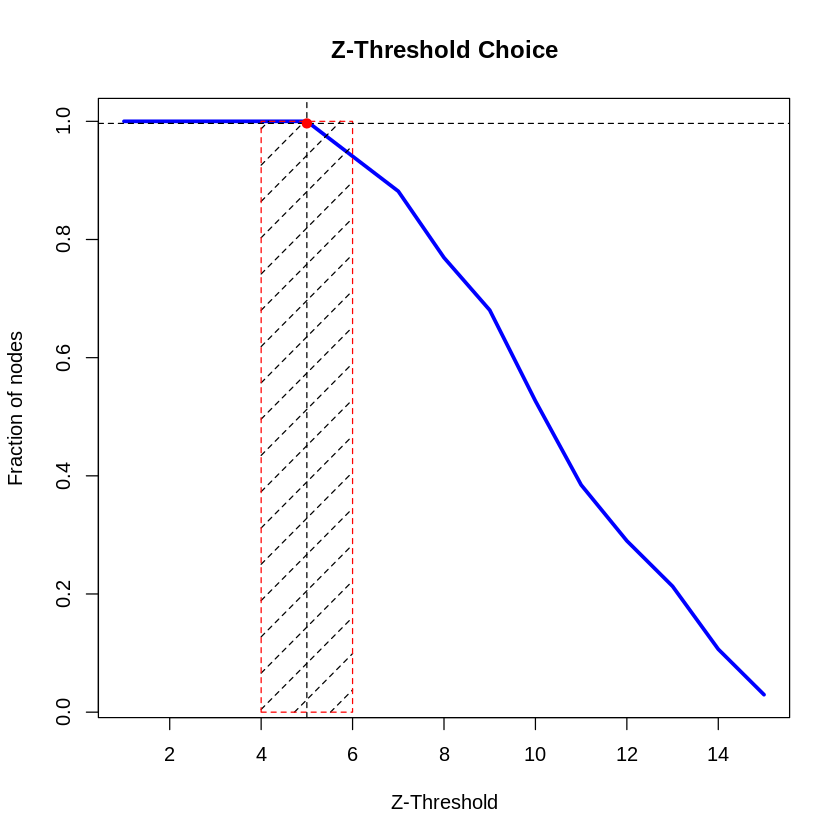

In [64]:
OptimalThresholdingZ <- function(dt, dt2, x){
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(dt), method = "pearson")
  co_net_corr_dataN <- cor(t(dt2), method = "pearson")
  
  # Application Z-Fisher Transform
  ZcoDataC <- log((1+co_net_corr_dataC)/(1-co_net_corr_dataC))/2
  ZcoDataN <- log((1+co_net_corr_dataN)/(1-co_net_corr_dataN))/2
  
  # Applying z-scores
  ZcoData <- (ZcoDataC-ZcoDataN)/sqrt((1/(nrow(rna_expr_data_C)-3)) + (1/(nrow(rna_expr_data_N)-3)))
  
  # Applying Z-tsh
  tshZ <- x
  ZcoData <- ifelse(ZcoData <= -abs(tshZ) | ZcoData >= abs(tshZ), 1, 0)
  
  gZ <- graph_from_adjacency_matrix(ZcoData, diag = FALSE)
  
  fracNodes_C <- fractionNodes(gZ)
  
  return(fracNodes_C)
}

possibletshZ <- seq(1, 15, by = 1) # the behaviour is symmetric
densitiesZ <- unlist(lapply(possibletshZ, function(x){
  return(OptimalThresholdingZ(rna_expr_data_C, rna_expr_data_N, x))
}))

plot(possibletshZ, densitiesZ, col = "blue", type = "l", lwd = 3, xlab = "Z-Threshold", ylab = "Fraction of nodes", main = "Z-Threshold Choice")
rect(xleft = 4, ybottom = 0.0, xright = 6, ytop = 1.0, density = 5, border = "red", lty = 2, lwd = 1)

# hard Zthresholding
abline(h = 0.9965, lty=2)
abline(v = 5, lty=2)
points(x = 5, y = 0.9965, pch = 20, col = "red", cex = 1.5)

### IV.2 Correlation and Z-Transform

In [65]:
# create the correlation datasets for plotting the network for each graph
co_net_corr_dataC <- cor(t(rna_expr_data_C), method = "pearson")
co_net_corr_dataN <- cor(t(rna_expr_data_N), method = "pearson")

# Application Z-Fisher Transform
ZcoDataC <- log((1+co_net_corr_dataC)/(1-co_net_corr_dataC))/2
ZcoDataN <- log((1+co_net_corr_dataN)/(1-co_net_corr_dataN))/2

# Applying z-scores
ZcoData <- (ZcoDataC-ZcoDataN)/sqrt((1/(nrow(rna_expr_data_C)-3)) + (1/(nrow(rna_expr_data_N)-3)))

# Z-Threshold it
tshZ <- 5 
ZcoData <- ifelse(ZcoData <= -abs(tshZ) | ZcoData >= abs(tshZ), 1, 0)

### IV.3 Hubs of genes
See III.4 as a reference for this part

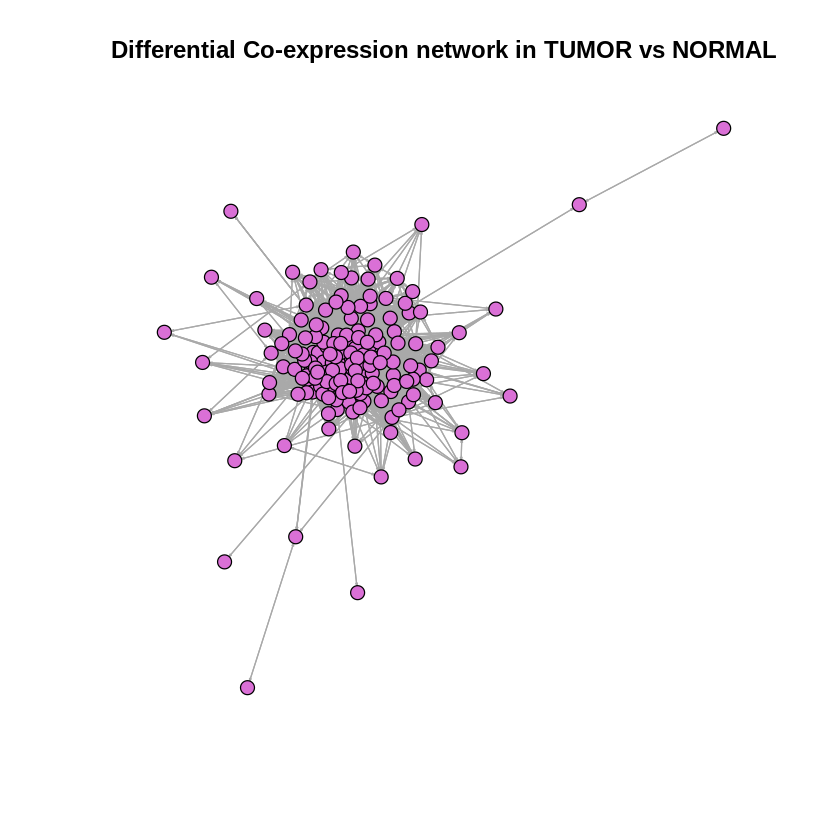

character(0)


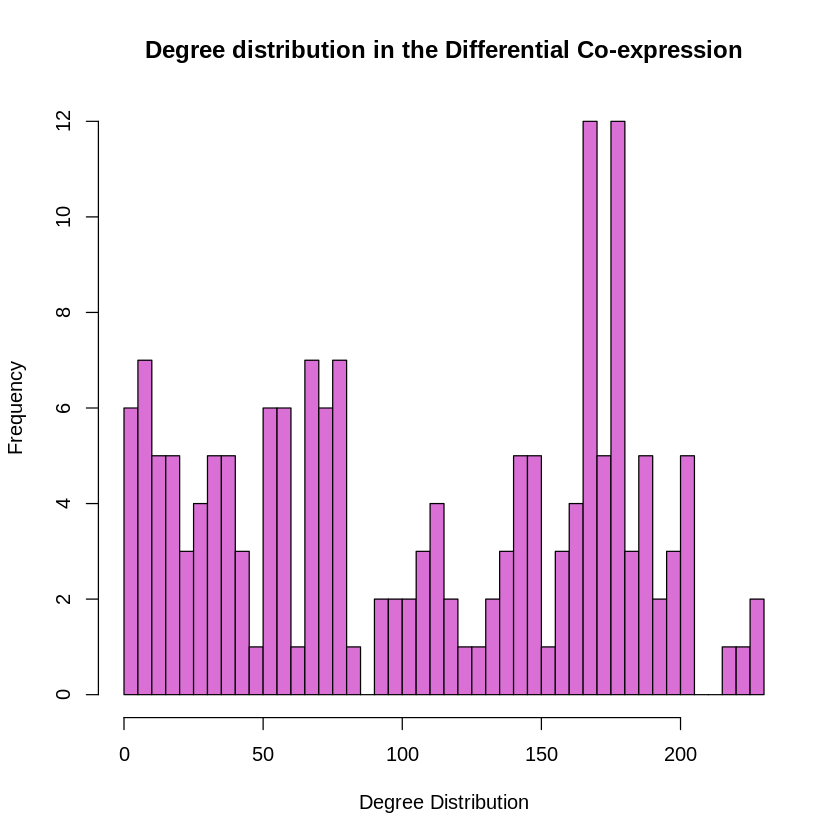

In [66]:
# Get the graph and plot it
gZcoData <- graph_from_adjacency_matrix( ZcoData, diag = FALSE)
plot(gZcoData, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "orchid", main = "Differential Co-expression network in TUMOR vs NORMAL",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.auto, vertex.label = NA)

# dgZcoData degree distribution
dgZcoData <- degree(gZcoData)
hist(dgZcoData[dgZcoData != 0], main = "Degree distribution in the Differential Co-expression", col = "orchid", xlab = "Degree Distribution", breaks = 50)

# extract the 5% of HUBS, in their conditions
hubs_Z <- sort(degree(gZcoData, v = V(gZcoData), mode = "all"), decreasing = TRUE) # normalized TRUE
hubs_Z <- hubs_Z[1:floor(0.05 * length(hubs_Z))] 

# Comparing hubs in TUMORS and Z-Tum vs. Z-Norm
namesHUBS_Z <- names(hubs_Z)
namesHUBS_C <- names(hubs_C)
namesHUBS_N <- names(hubs_N)

hubs_commonZC <- intersect(namesHUBS_C, namesHUBS_Z) 
print(hubs_commonZC)

## Part V
## Patient Similarity Network (PSN)
We have graph $gC$ (see III.5) we would like to run community detection on using the Louvain method (see https://en.wikipedia.org/wiki/Louvain_method) in igraph. For further references see https://kateto.net/networks-r-igraph and https://air.unimi.it/retrieve/1c59e885-670b-4320-89e5-fd9f49691632/bbac207.pdf. 

In [1]:
# make gC undirected (louvian method implemented only in this case)

DM1 <- as.matrix(t(rna_expr_data_C))
G1 <- graph.adjacency(DM1, mode = "undirected", weighted = TRUE, diag = TRUE)

ERROR: ignored

Community sizes
  1 
169 

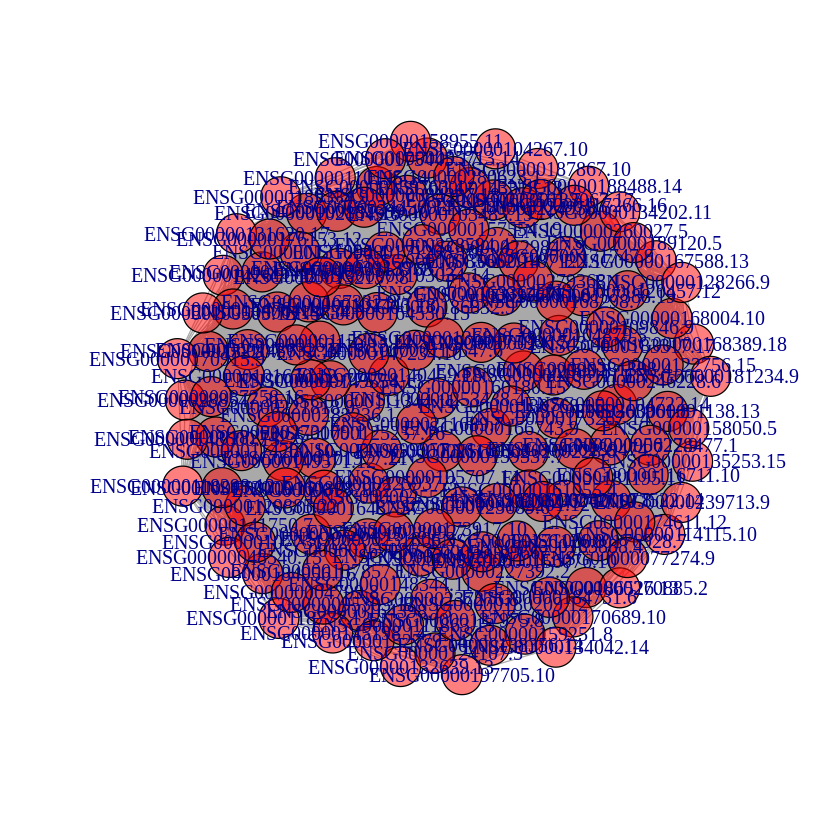

In [138]:
# communities
clusterlouvain <- cluster_louvain(G1)
plot(G1, vertex.color=rainbow(3, alpha=0.5)[clusterlouvain$membership])
sizes(clusterlouvain)

## PART VI
## Optional Tasks

#### VI.1 Compare the network topology obtained applying hard-thresholding and soft-thresholding

##### Case of Patients with Cancer

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 169 of 169
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0689  0.311         0.1020 41.3000  40.90000 66.500
2      2   0.5420 -0.498         0.4640 16.5000  14.50000 37.400
3      3   0.7740 -0.792         0.7720  8.1800   6.07000 23.900
4      4   0.7910 -0.927         0.7900  4.5900   2.68000 16.300
5      5   0.8730 -0.992         0.8700  2.7800   1.43000 11.600
6      6   0.9020 -1.080         0.9240  1.7700   0.82000  8.490
7      7   0.8300 -1.130         0.8300  1.1800   0.45400  6.410
8      8   0.8020 -1.180         0.7970  0.8110   0.29600  4.950
9      9   0.8600 -1.180         0.8760  0.5720   0.18500  3.890
10    10   0.1710 -2.110        -0.0654  0.4130   0.12800  3.090
11    12   0.1720 -2.020        -0.0616  0.2270   0.05450  2.020
12    14   0.2070 -2.090         0.0155  0.1330   0.02250  1.360
13    16   0.2740 -3.140         0.2230  0.0815

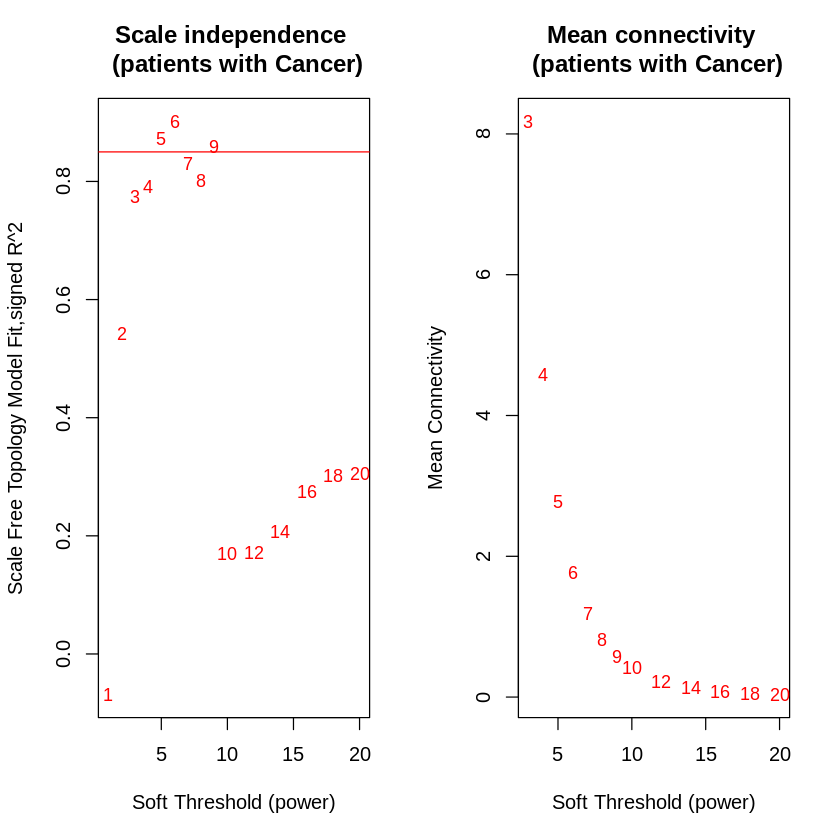

scaleFreeRsquared,slope
<dbl>,<dbl>
0.91,-1.74


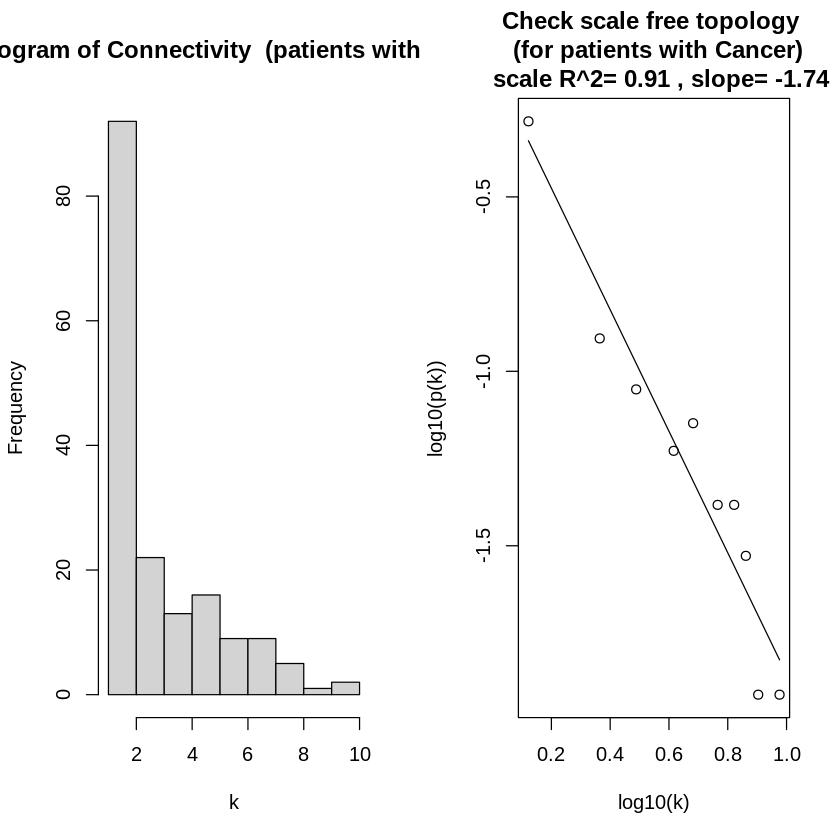

In [111]:
# Choose a set of soft-thresholding powers 
# See https://support.bioconductor.org/p/87024/
powers = c(c(1:10), seq(from = 12, to=20, by=2)) 

# Call the WGCNA function 
sft = pickSoftThreshold(t(rna_expr_data_C), powerVector = powers, verbose = 5,blockSize=8504) 

par(mfrow = c(1,2))

# Analysis of the scale-free fit index for various soft-thresholding powers (??)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n", main = "Scale independence \n (patients with Cancer)");
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers,cex=0.9,col="red")
abline(h=0.85,col="red") # this line corresponds to using an R^2 cut-off of 0.85

#Analysis of the mean connectivity for various soft-thresholding powers  
plot(sft$fitIndices[-(1:2),1], sft$fitIndices[-(1:2),5], xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n", main = "Mean connectivity \n (patients with Cancer)") 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=0.9, col="red")

#it seems that 6 could be a power soft threshold to ensure a scale-free network, so:
soft_th = 6

#calculate the corresponding adjacency matrix:
adjacency=abs(cor(t(rna_expr_data_C),use="p"))^soft_th

# network connectivities:
k=as.vector(apply(adjacency,2,sum))

# The following histogram shows the frequency distribution of the connectivity;
# we can see a large number of low connected genes, and a small number 
# of highly connected genes:
hist(k, main="Histogram of Connectivity  (patients with Cancer)")

# The following log-log plot shows an R2 (the scale-free topology index)
# of 0.95, which means that this is a scale-free network.
scaleFreePlot(k, main="Check scale free topology \n (for patients with Cancer)\n")


##### Case of Patients without Cancer 

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 169 of 169
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.867  1.680         0.8870  71.300    78.800 101.00
2      2    0.251  0.315         0.1020  40.600    43.800  73.50
3      3    0.161 -0.256        -0.0591  26.300    25.200  57.80
4      4    0.454 -0.533         0.3050  18.400    15.600  47.40
5      5    0.574 -0.672         0.4760  13.500     9.790  39.90
6      6    0.580 -0.858         0.5200  10.300     6.470  34.10
7      7    0.641 -0.868         0.6120   8.060     4.350  29.50
8      8    0.671 -0.917         0.6330   6.420     2.960  25.80
9      9    0.643 -1.030         0.6190   5.200     2.040  22.70
10    10    0.677 -1.030         0.6820   4.260     1.450  20.10
11    12    0.736 -1.040         0.7540   2.960     0.855  16.00
12    14    0.203 -2.250         0.1210   2.110     0.441  12.90
13    16    0.210 -2.130         0.1290   1.550

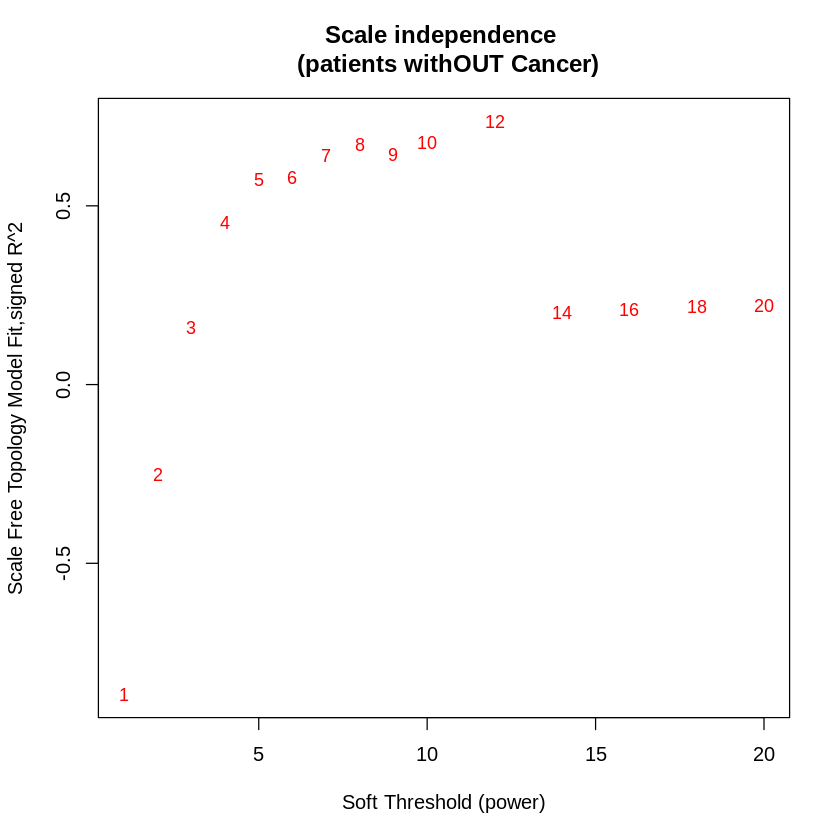

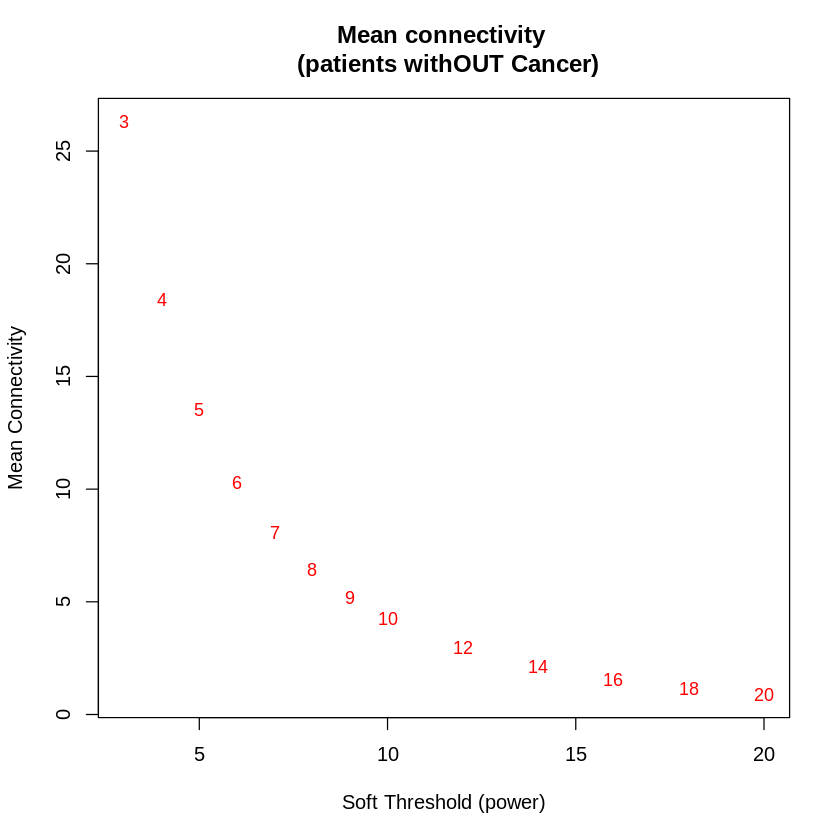

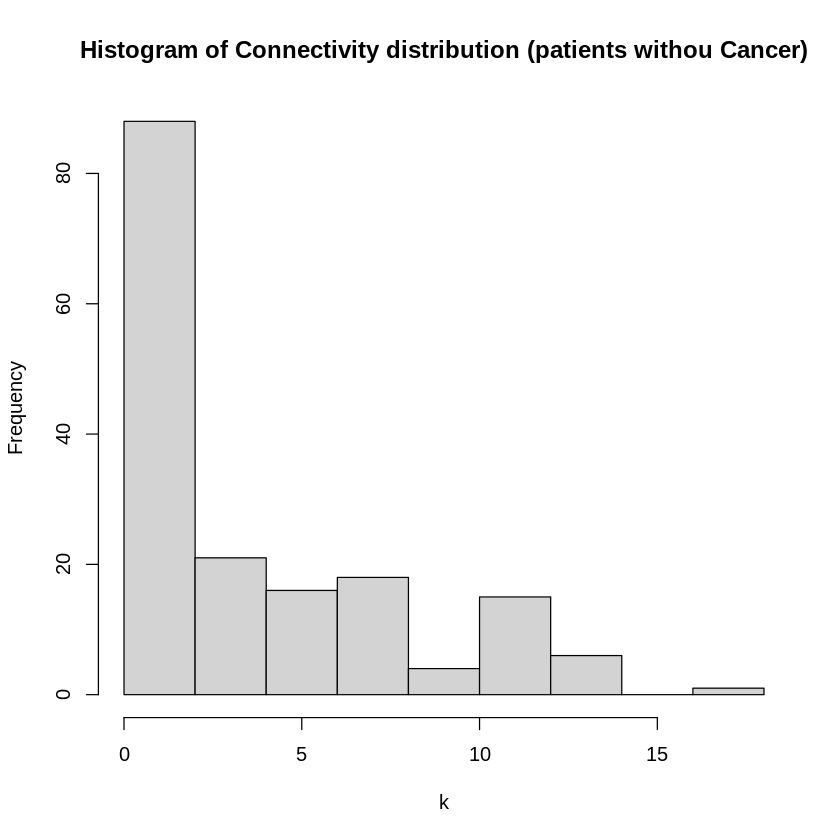

scaleFreeRsquared,slope
<dbl>,<dbl>
0.74,-1.56


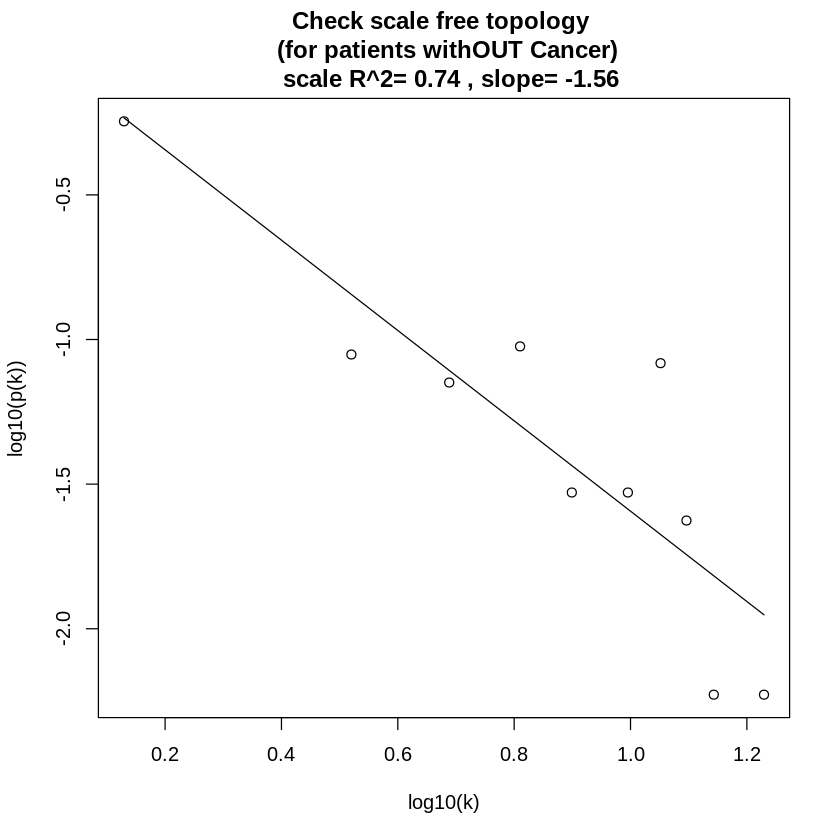

In [112]:
# Choose a set of soft-thresholding powers 
powers = c(c(1:10), seq(from = 12, to=20, by=2)) 

# Call the WGCNA function 
sft = pickSoftThreshold(t(rna_expr_data_N), powerVector = powers, verbose = 5,blockSize=8504) 

# Analysis of the scale-free fit index for various soft-thresholding powers (??)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n", main = "Scale independence \n (patients withOUT Cancer)");
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers,cex=0.9,col="red")
abline(h=0.85,col="red") # this line corresponds to using an R^2 cut-off of 0.85

#Analysis of the mean connectivity for various soft-thresholding powers  
plot(sft$fitIndices[-(1:2),1], sft$fitIndices[-(1:2),5], xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n", main = "Mean connectivity \n (patients withOUT Cancer)") 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=0.9, col="red")

#it seems that 12 could be a power soft threshold to ensure a scale-free network, so:
soft_th = 12

#calculate the corresponding adjacency matrix:
adjacency=abs(cor(t(rna_expr_data_N),use="p"))^soft_th

# network connectivity:
k=as.vector(apply(adjacency,2,sum))

# The following histogram shows the frequency distribution of the connectivity;
# we can see a large number of low connected genes, and a small number 
# of highly connected genes:
hist(k, main="Histogram of Connectivity distribution (patients withou Cancer)")

# The following log-log plot shows an R2 (the scale-free topology index)
# of 0.94, which means that this is a scale-free network.
scaleFreePlot(k, main="Check scale free topology \n (for patients withOUT Cancer)\n")

### VI.2 Check the overlapping between the 5% of the nodes with highest CI values and the "Degree"-based hubs

In [113]:
comparisonCIwithDegreeHUBS <- function(graph, TypegHUBS) {
  
  # calculates the centralities
  CI_index_between <- sort(betweenness(graph), decreasing = T) # Betweenness centrality
  CI_index_closeness <- sort(closeness(graph), decreasing = T) # Closeness centrality
  CI_index_eigen <- sort(eigen_centrality(graph)$vector, decreasing = T) # Eigen centrality
  
  # extract the hubs
  hubs_CI_between <- CI_index_between[1:floor(0.05 * length(CI_index_between))] # Find the Hubs (top 5%)
  namesHUBS_CI_between <- names(hubs_CI_between) # and their names
  
  hubs_CI_closeness <- CI_index_closeness[1:floor(0.05 * length(CI_index_closeness))] # Find the Hubs (top 5%)
  namesHUBS_CI_closeness <- names(hubs_CI_closeness) # and their names
  
  hubs_CI_eigen <- CI_index_eigen[1:floor(0.05 * length(CI_index_eigen))] # Find the Hubs (top 5%)
  namesHUBS_CI_eigen <- names(hubs_CI_eigen) # and their names
  
  # put all in a list
  localCentralities <- list(
    betweeness = intersect(TypegHUBS, namesHUBS_CI_between),
    closeness = intersect(TypegHUBS, namesHUBS_CI_closeness),
    eigen = intersect(TypegHUBS, namesHUBS_CI_eigen)
  )
  
  return(localCentralities) #Let's see which centralityIndex-based hubs are also "Degree"-based hubs
}

plotCommonHUBS <- function(matrix_type, graph_type, LocalCentralities_type){ # to be complete!!
  
  for(hubs_type in names(LocalCentralities_type)){
    hub_common <- LocalCentralities_type[[hubs_type]]
    
    V(graph_type)$color <- ifelse(V(graph_type)$name %in% hub_common, "red", "green")
    
    plot(graph_type, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = V(graph_type)$color, main = paste(hubs_type, "=", length(hub_common), "hubs in common", sep = " "),
         arrow.width=.1, edge.arrow.size=.1, layout= layout_on_sphere, vertex.label = NA)
  }
  
}

$betweeness
[1] "ENSG00000120885.22" "ENSG00000239713.9" 

$closeness
[1] "ENSG00000138356.14" "ENSG00000120885.22" "ENSG00000170915.9" 
[4] "ENSG00000131620.17" "ENSG00000239713.9" 

$eigen
[1] "ENSG00000138356.14" "ENSG00000120885.22" "ENSG00000170915.9" 
[4] "ENSG00000176928.7"  "ENSG00000244509.4"  "ENSG00000131620.17"

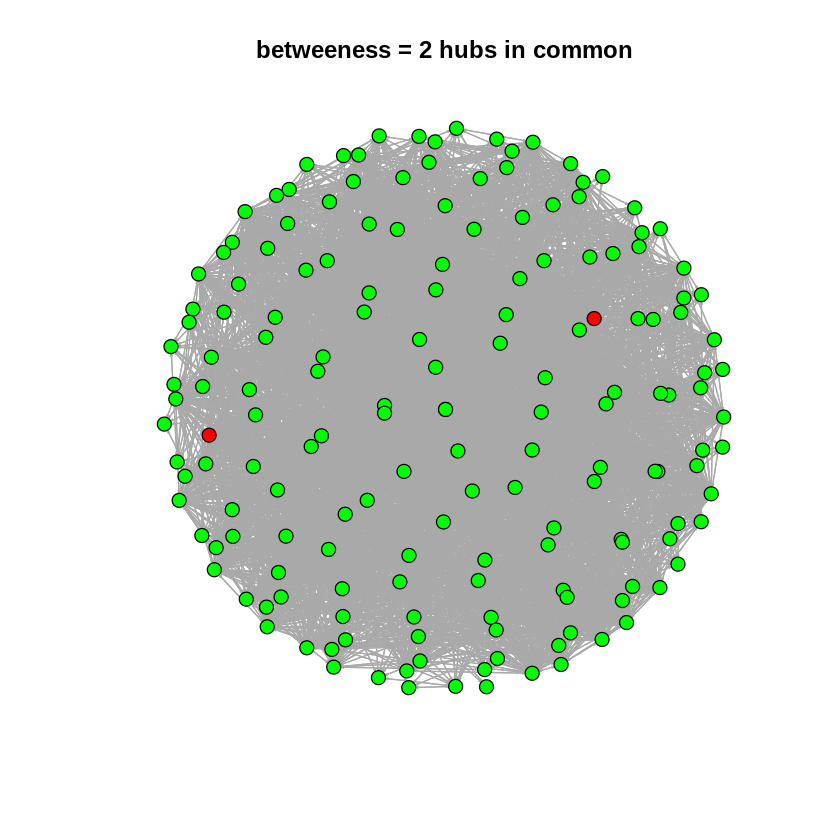

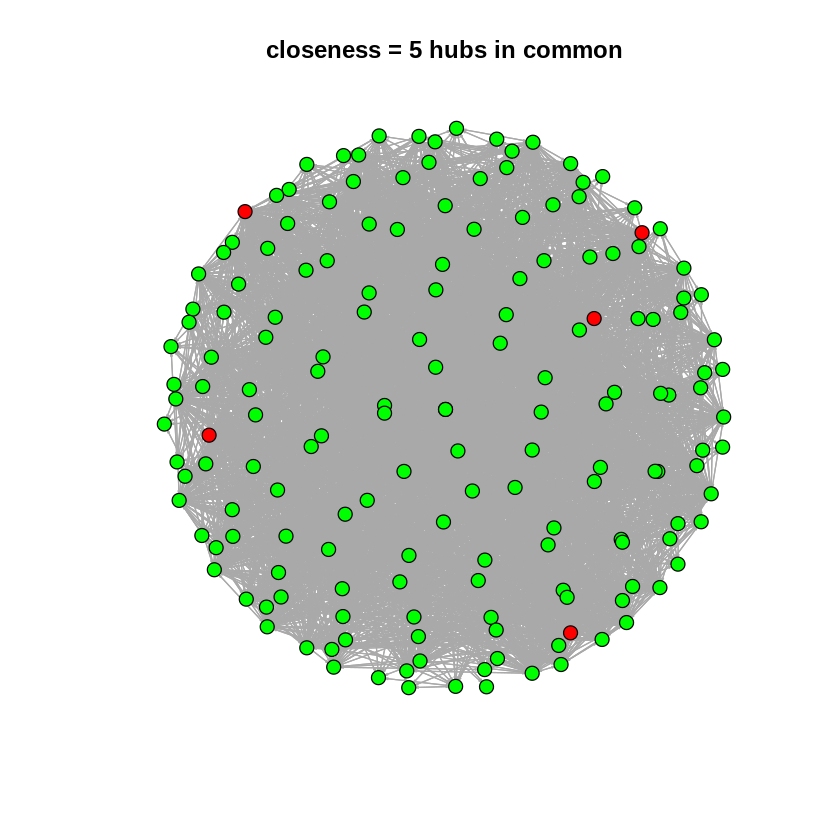

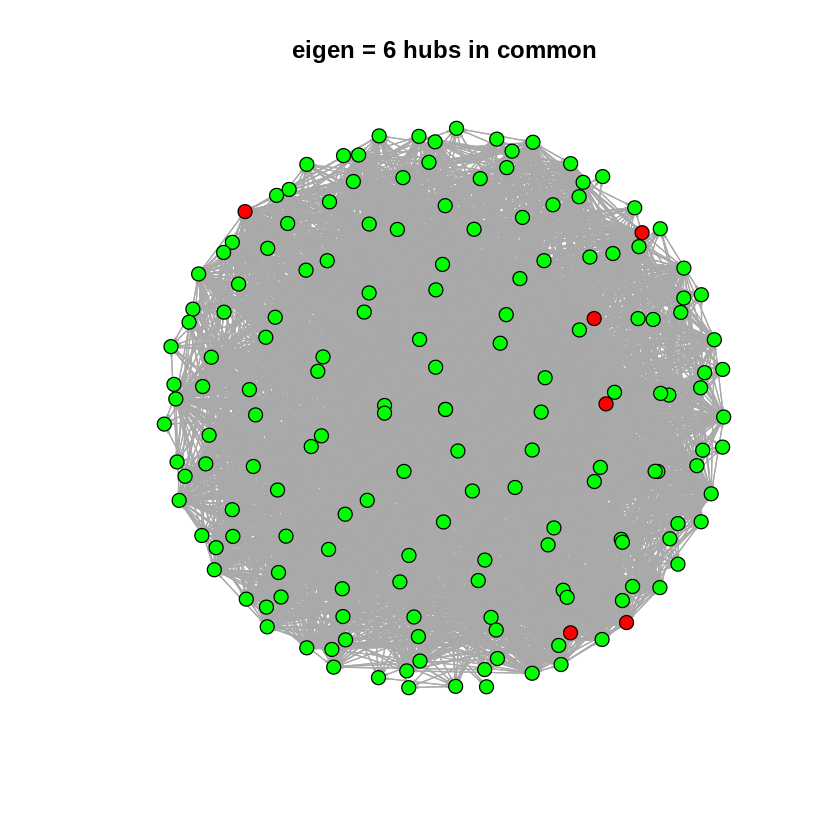

In [114]:
# Centralities and common hubs (Tumor)
LocalCentralities_C <- comparisonCIwithDegreeHUBS(gC, namesHUBS_C); LocalCentralities_C 
plotCommonHUBS(co_net_corrBinary_dataC, gC, LocalCentralities_C) 

$betweeness
[1] "ENSG00000260228.6" "ENSG00000255545.8"

$closeness
[1] "ENSG00000260228.6"  "ENSG00000211695.2"  "ENSG00000119547.6" 
[4] "ENSG00000136840.19" "ENSG00000125257.16" "ENSG00000176928.7" 
[7] "ENSG00000103485.19" "ENSG00000255545.8" 

$eigen
[1] "ENSG00000260228.6"  "ENSG00000211695.2"  "ENSG00000136840.19"
[4] "ENSG00000125257.16" "ENSG00000103485.19"

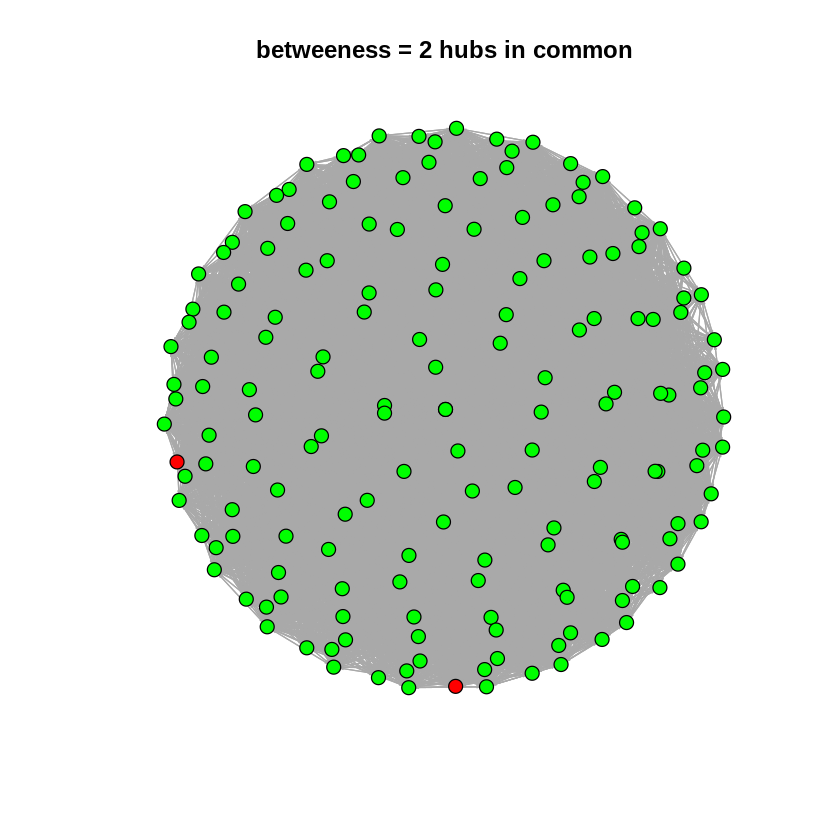

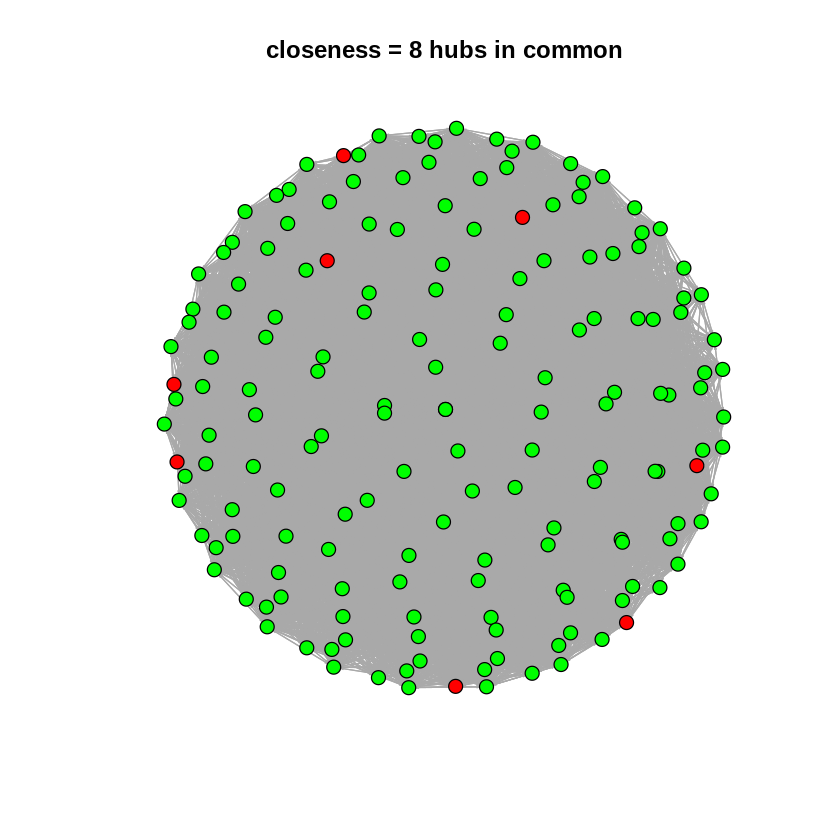

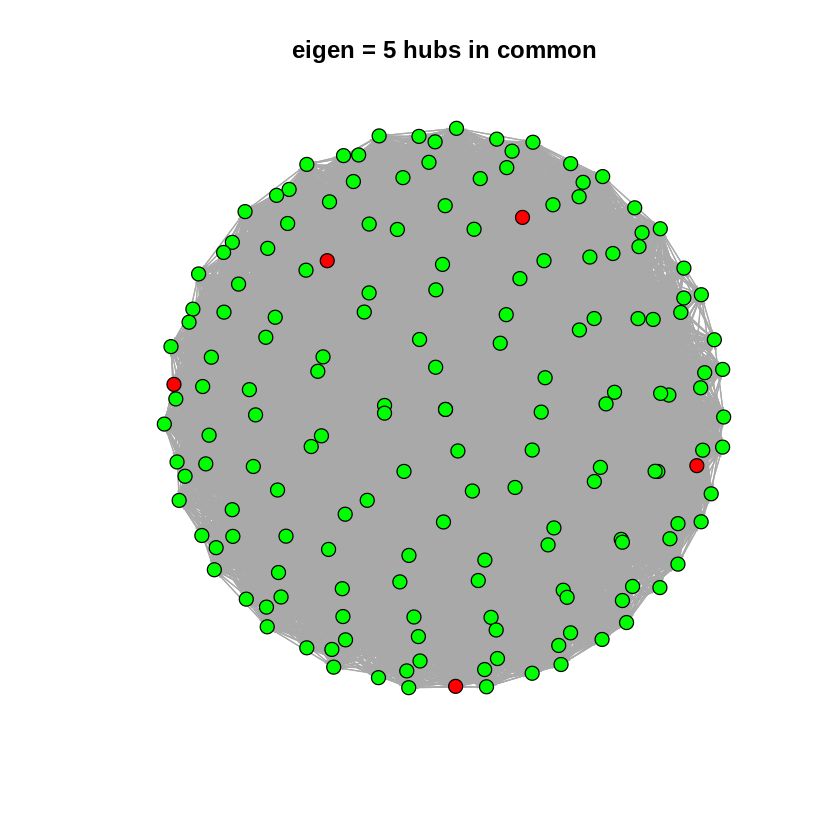

In [115]:
# Centralities and common hubs (Normal)
LocalCentralities_N <- comparisonCIwithDegreeHUBS(gN, namesHUBS_N); LocalCentralities_N 
plotCommonHUBS(co_net_corrBinary_dataN, gN, LocalCentralities_N) 

### VI.3 Perform the study using a different similarity measure

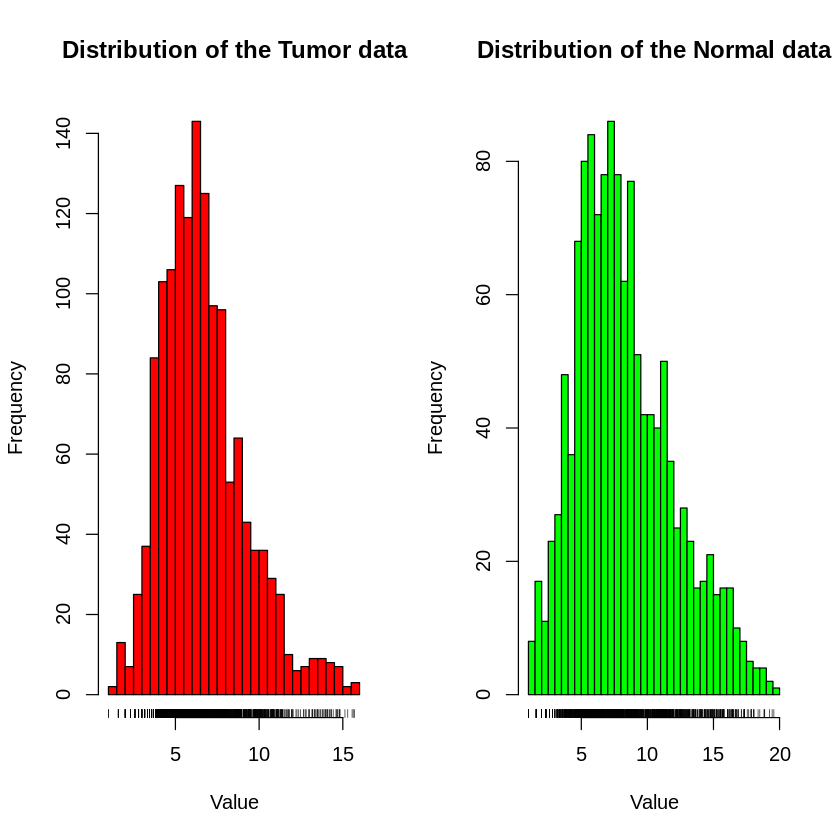

In [116]:
# Print the values to check which value of correlation is better
par(mfrow=c(1,2))
hist(rna_expr_data_C[upper.tri(rna_expr_data_C)], main = "Distribution of the Tumor data", col = "red", xlab = "Value", breaks = 50)
rug(rna_expr_data_C[upper.tri(rna_expr_data_C)])
hist(rna_expr_data_N[upper.tri(rna_expr_data_N)], main = "Distribution of the Normal data", col = "green", xlab = "Value", breaks = 50)
rug(rna_expr_data_N[upper.tri(rna_expr_data_N)])

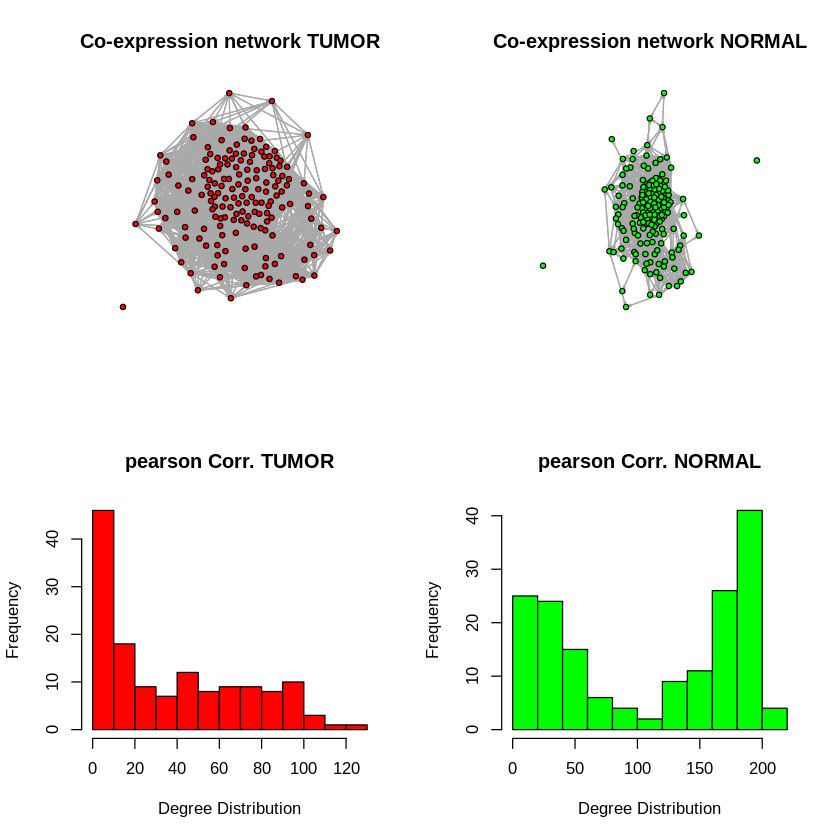

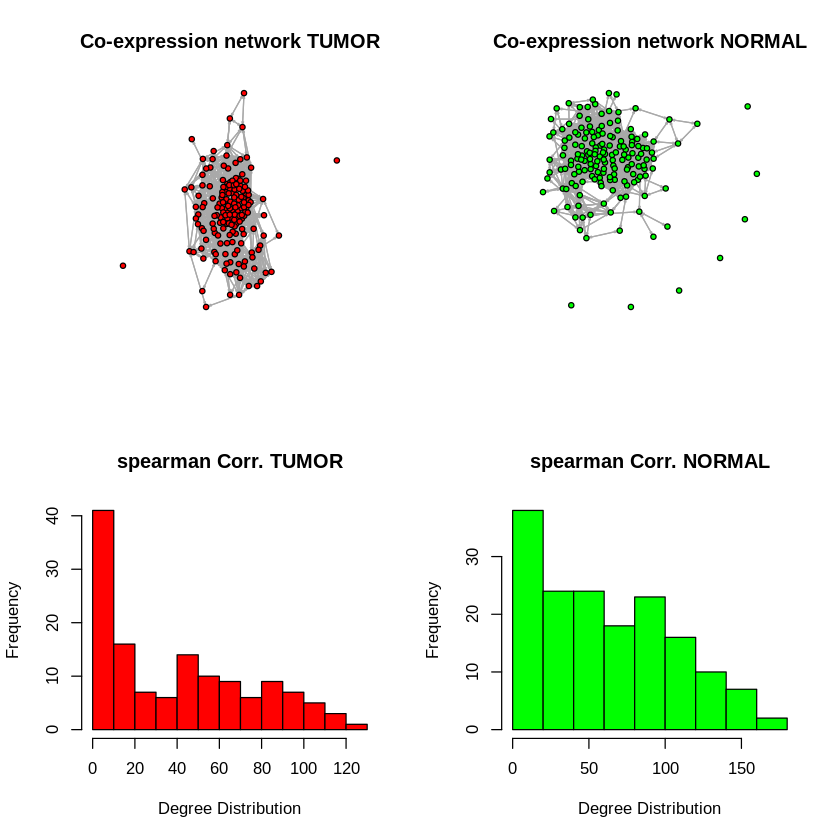

In [117]:
par(mfrow=c(2,2))
method_correlation <- c("pearson", "spearman")
for (i in  method_correlation) {
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(rna_expr_data_C), method = i)
  co_net_corr_dataN <- cor(t(rna_expr_data_N), method = i)
  
  # binary masks
  tsh <- 0.55
  co_net_corrBinary_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
  co_net_corrBinary_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)
  
  # create the graph
  gC <- graph_from_adjacency_matrix(co_net_corrBinary_dataC, diag = FALSE)
  plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "RED", main = "Co-expression network TUMOR",
       arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA)
  
  
  gN <- graph_from_adjacency_matrix( co_net_corrBinary_dataN, diag = FALSE)
  plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "green", main = "Co-expression network NORMAL",
       arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 
  
  # degree distribution of the graphs
  dgC <- degree(gC)
  dgN <- degree(gN)
  hist(dgC[dgC != 0], main = paste(i, "Corr. TUMOR", sep = " ") , col = "red", xlab = "Degree Distribution")
  hist(dgN[dgN != 0], main = paste(i, "Corr. NORMAL", sep = " "), col = "green", xlab = "Degree Distribution")
  
  # extract the 5% of HUBS, in their conditions
  hubs_C <- sort(degree(gC, v = V(gC), mode = "all"), decreasing = TRUE) # normalized TRUE
  hubs_C <- hubs_C[1:floor(0.05 * length(hubs_C))] 
  hubs_N <- sort(degree(gN, v = V(gN), mode = "all"), decreasing = TRUE) # normalized TRUE
  hubs_N <- hubs_N[1:floor(0.05 * length(hubs_N))] 
  
  nam <- paste("hubs_C_", i, sep = "")
  assign(nam, names(hubs_C))
  mamt <- paste("hubs_N_", i, sep = "")
  assign(mamt, names(hubs_N))
}

In [118]:
# common hubs

intersect(hubs_N_pearson, hubs_N_spearman) 
intersect(hubs_C_pearson, hubs_C_spearman) 

[1] "ENSG00000136840.19" "ENSG00000170915.9"  "ENSG00000120885.22"
[4] "ENSG00000135253.15"

[1] "ENSG00000244509.4"  "ENSG00000128266.9"  "ENSG00000103485.19"
[4] "ENSG00000170915.9"  "ENSG00000138356.14" "ENSG00000120885.22"
[7] "ENSG00000131620.17"